# Pip Install

In [1]:
!pip install mlxtend --user
!pip install lightgbm --user
!pip install xgboost --user
!pip install plotly --user

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 15.3 MB 29.2 MB/s            
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


# Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy as sp
import math
import seaborn as sn
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from datetime import datetime
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
import warnings
from sklearn.inspection import permutation_importance
warnings.filterwarnings('ignore')

# Dataset Build (Dividing Winter and Summer) (Combining Parents and Not) (within Acceptable Dry/Wet Yield Ratio Range)

In [46]:
df = pd.read_csv('/mnt/Datasets/merged_df_wet_and_dry_3_20_23.csv').drop(columns = ['Unnamed: 0'])
df['dry_wet_ratio'] = df['Enter Dry Finished Yield Mass (kg)'] / df['Enter Total Wet Mass Harvested (kg)']
df_season = pd.read_excel('/mnt/Datasets/PC003_consolidated_new (1).xlsx')
df_season['Field Name'] = df_season['Contrato legal'].str[6:]
df_season = df_season[['Field Name', 'Safra']]
df_season = df_season.rename(columns = {'Safra': 'Season', 'Field Name': 'Field_Name'})
df_season = df_season.drop_duplicates().reset_index(drop = True)
df = df.merge(df_season, on = 'Field_Name', how = 'left')
df_combined_parents = df
df_combined_parents['Total_N'] = df_combined_parents['N_as_Urea_kg_per_Ha'] + df_combined_parents['N_as_Nitrate_kg_per_Ha'] + df_combined_parents['N_as_Ammonium_kg_per_Ha']
df_combined_parents['Total_P'] = df_combined_parents['P_as_Phosphorus_kg_per_Ha'] + df_combined_parents['P_as_P2O5_kg_per_Ha']
df_combined_parents['Total_K'] = df_combined_parents['K_as_Potassium_kg_per_Ha'] + df_combined_parents['K_as_K2O_kg_per_Ha']
df_combined_parents = df_combined_parents.drop(columns = ['N_as_Urea_kg_per_Ha', 'N_as_Nitrate_kg_per_Ha', 'N_as_Ammonium_kg_per_Ha', \
                                                          'P_as_Phosphorus_kg_per_Ha', 'P_as_P2O5_kg_per_Ha'])

#Summer
df_summer = df[df['Season'] == 'SUMMER'].reset_index(drop = True)[['Crop_Protection_Application_Doses', 'Soil_Organic_Matter', 'Yield_kg_per_Ha', \
                                                                  'N_as_Urea_kg_per_Ha', 'N_as_Nitrate_kg_per_Ha', 'N_as_Ammonium_kg_per_Ha', 'P_as_Phosphorus_kg_per_Ha', \
                                                                   'P_as_P2O5_kg_per_Ha', 'K_as_Potassium_kg_per_Ha', 'K_as_K2O_kg_per_Ha', 'dry_wet_ratio']]
df_summer_combined_parents = df_combined_parents[df_combined_parents['Season'] == 'SUMMER'].reset_index(drop = True)[['Crop_Protection_Application_Doses', 'Soil_Organic_Matter', 'Yield_kg_per_Ha', \
                                                                  'Total_N', 'Total_P', 'Total_K', 'dry_wet_ratio']]
df_dy_wy_ratio_summer = df_summer[(df_summer['dry_wet_ratio'] > .2) & (df_summer['dry_wet_ratio'] < .6)].reset_index(drop = True).drop(columns = ['dry_wet_ratio'])
df_dy_wy_ratio_summer_combined_parents  = df_summer_combined_parents[(df_summer_combined_parents['dry_wet_ratio'] > .2) & (df_summer_combined_parents['dry_wet_ratio'] < .6)].reset_index(drop = True).drop(columns = ['dry_wet_ratio'])
df_summer = df_summer.drop(columns = ['dry_wet_ratio'])
df_summer_combined_parents = df_summer_combined_parents.drop(columns = ['dry_wet_ratio'])

#Winter
df_winter = df[df['Season'] == 'WINTER'].reset_index(drop = True)[['Crop_Protection_Application_Doses', 'Soil_Organic_Matter', 'Yield_kg_per_Ha', \
                                                                  'N_as_Urea_kg_per_Ha', 'N_as_Nitrate_kg_per_Ha', 'N_as_Ammonium_kg_per_Ha', 'P_as_Phosphorus_kg_per_Ha', \
                                                                   'P_as_P2O5_kg_per_Ha', 'K_as_Potassium_kg_per_Ha', 'K_as_K2O_kg_per_Ha', 'dry_wet_ratio']]
df_winter_combined_parents = df_combined_parents[df_combined_parents['Season'] == 'WINTER'].reset_index(drop = True)[['Crop_Protection_Application_Doses', 'Soil_Organic_Matter', 'Yield_kg_per_Ha', \
                                                                  'Total_N', 'Total_P', 'Total_K', 'dry_wet_ratio']]
df_dy_wy_ratio_winter  = df_winter[(df_winter['dry_wet_ratio'] > .2) & (df_winter['dry_wet_ratio'] < .6)].reset_index(drop = True).drop(columns = ['dry_wet_ratio'])
df_dy_wy_ratio_winter_combined_parents  = df_winter_combined_parents[(df_winter_combined_parents['dry_wet_ratio'] > .2) & (df_winter_combined_parents['dry_wet_ratio'] < .6)].reset_index(drop = True).drop(columns = ['dry_wet_ratio'])
df_winter = df_winter.drop(columns = ['dry_wet_ratio'])
df_winter_combined_parents = df_winter_combined_parents.drop(columns = ['dry_wet_ratio'])
print(display(df_winter_combined_parents))

df_dy_wy_ratio_summer.to_csv('/mnt/Wet_yield_prediction/Organized_Work/Datasets/df_dy_wy_ratio_summer.csv')
df_dy_wy_ratio_summer_combined_parents.to_csv('/mnt/Wet_yield_prediction/Organized_Work/Datasets/df_dy_wy_ratio_summer_combined_parents.csv')
df_summer.to_csv('/mnt/Wet_yield_prediction/Organized_Work/Datasets/df_summer.csv')
df_summer_combined_parents.to_csv('/mnt/Wet_yield_prediction/Organized_Work/Datasets/df_summer_combined_parents.csv')
df_dy_wy_ratio_winter.to_csv('/mnt/Wet_yield_prediction/Organized_Work/Datasets/df_dy_wy_ratio_winter.csv')
df_dy_wy_ratio_winter_combined_parents.to_csv('/mnt/Wet_yield_prediction/Organized_Work/Datasets/df_dy_wy_ratio_winter_combined_parents.csv')
df_winter.to_csv('/mnt/Wet_yield_prediction/Organized_Work/Datasets/df_winter.csv')
df_winter_combined_parents.to_csv('/mnt/Wet_yield_prediction/Organized_Work/Datasets/df_winter_combined_parents.csv')

,Crop_Protection_Application_Doses,Soil_Organic_Matter,Yield_kg_per_Ha,Total_N,Total_P,Total_K
0,14.0,2.500000,3049.333333,205.5,48.0,48.0
1,18.0,2.500000,3575.055556,492.0,216.0,216.0
2,13.0,2.500000,3116.200000,198.0,60.0,60.0
3,9.0,2.500000,7678.888889,202.4,95.2,96.0
4,9.0,2.500000,7756.363636,179.4,95.2,90.0
...,...,...,...,...,...,...
500,15.0,2.597851,4073.493976,92.0,0.0,0.0
501,17.0,3.120000,6969.677419,184.0,0.0,0.0
502,19.0,2.930000,6969.636364,92.0,0.0,0.0
503,17.0,3.240000,7954.666667,207.0,0.0,0.0


None


In [24]:
df = pd.read_csv('/mnt/Datasets/merged_df_wet_and_dry_3_20_23.csv').drop(columns = ['Unnamed: 0'])
df['dry_wet_ratio'] = df['Enter Dry Finished Yield Mass (kg)'] / df['Enter Total Wet Mass Harvested (kg)']
df_season = pd.read_excel('/mnt/Datasets/PC003_consolidated_new (1).xlsx')
df_season['Field Name'] = df_season['Contrato legal'].str[6:]
df_season = df_season[['Field Name', 'Safra']]
df_season = df_season.rename(columns = {'Safra': 'Season', 'Field Name': 'Field_Name'})
df_season = df_season.drop_duplicates().reset_index(drop = True)
df = df.merge(df_season, on = 'Field_Name', how = 'left')
df_combined_parents = df
df_combined_parents['Total_N'] = df_combined_parents['N_as_Urea_kg_per_Ha'] + df_combined_parents['N_as_Nitrate_kg_per_Ha'] + df_combined_parents['N_as_Ammonium_kg_per_Ha']
df_combined_parents['Total_P'] = df_combined_parents['P_as_Phosphorus_kg_per_Ha'] + df_combined_parents['P_as_P2O5_kg_per_Ha']
df_combined_parents['Total_K'] = df_combined_parents['K_as_Potassium_kg_per_Ha'] + df_combined_parents['K_as_K2O_kg_per_Ha']
df_combined_parents = df_combined_parents.drop(columns = ['N_as_Urea_kg_per_Ha', 'N_as_Nitrate_kg_per_Ha', 'N_as_Ammonium_kg_per_Ha', \
                                                          'P_as_Phosphorus_kg_per_Ha', 'P_as_P2O5_kg_per_Ha'])

#Winter
df_winter = df[df['Season'] == 'WINTER'].reset_index(drop = True)[['Field_Name', 'Crop_Protection_Application_Doses', 'Soil_Organic_Matter', 'Yield_kg_per_Ha', \
                                                                  'N_as_Urea_kg_per_Ha', 'N_as_Nitrate_kg_per_Ha', 'N_as_Ammonium_kg_per_Ha', 'P_as_Phosphorus_kg_per_Ha', \
                                                                   'P_as_P2O5_kg_per_Ha', 'K_as_Potassium_kg_per_Ha', 'K_as_K2O_kg_per_Ha', 'dry_wet_ratio']]
df_winter_combined_parents = df_combined_parents[df_combined_parents['Season'] == 'WINTER'].reset_index(drop = True)[['Field_Name', 'Crop_Protection_Application_Doses', 'Soil_Organic_Matter', 'Yield_kg_per_Ha', \
                                                                  'Total_N', 'Total_P', 'Total_K', 'dry_wet_ratio']]

print(display(df_winter_combined_parents))

hybrid_df = pd.read_excel('/mnt/Datasets/PC003_consolidated_new (1).xlsx')[['Hy', 'Contrato legal', 'MPL/Ha Plan']]
hybrid_df = hybrid_df.rename(columns = {'Hy': 'Hybrid', 'Contrato legal': 'Field_Name', 'MPL/Ha Plan': 'Planned_Yield_kg_per_ha'})
print(display(hybrid_df))
hybrid_df['Planned_Yield_kg_per_ha'] = hybrid_df['Planned_Yield_kg_per_ha']*100
hybrid_df['Field_Name'] = hybrid_df['Field_Name'].str[6:]
hybrid_df = hybrid_df.drop_duplicates()
print(display(hybrid_df))

df_winter_combined_parents = df_winter_combined_parents.merge(hybrid_df, on = 'Field_Name', how = 'left')
print(display(df_winter_combined_parents))
print(len(df_winter_combined_parents['Hybrid'].unique()))

df_winter_combined_parents = df_winter_combined_parents.drop(columns = ['dry_wet_ratio'])
df_winter_combined_parents.to_csv('/mnt/Wet_yield_prediction/Organized_Work/Datasets/Prescription_Dataset_w_field_hybrid_planned_yield.csv')

,Field_Name,Crop_Protection_Application_Doses,Soil_Organic_Matter,Yield_kg_per_Ha,Total_N,Total_P,Total_K,dry_wet_ratio
0,M6I2035,14.0,2.500000,3049.333333,205.5,48.0,48.0,0.984915
1,M6I2036,18.0,2.500000,3575.055556,492.0,216.0,216.0,0.651101
2,M6I2037,13.0,2.500000,3116.200000,198.0,60.0,60.0,0.979334
3,M6I2009,9.0,2.500000,7678.888889,202.4,95.2,96.0,0.486109
4,M6I2010,9.0,2.500000,7756.363636,179.4,95.2,90.0,0.505298
...,...,...,...,...,...,...,...,...
500,M6I21197,15.0,2.597851,4073.493976,92.0,0.0,0.0,0.636321
501,M6I21199,17.0,3.120000,6969.677419,184.0,0.0,0.0,0.534597
502,M6I21200,19.0,2.930000,6969.636364,92.0,0.0,0.0,0.534605
503,M6I21201,17.0,3.240000,7954.666667,207.0,0.0,0.0,0.503101


None


,Hybrid,Field_Name,Planned_Yield_kg_per_ha
0,DKB265PRO3,844111M4V1934,69.0
1,AS1844PRO3,509966M6V1924,50.0
2,AG1051,795121M6V19115,98.0
3,DKB345PRO3,829401M4V1937,57.0
4,DKB363PRO3,824794M4V1938,52.0
...,...,...,...
7151,DKB360PRO3,795152M4I2324,63.0
7152,DKB360PRO3,797161M4I2305,63.0
7153,AG7088PRO4,782068M4I2315,55.0
7154,AS1596TRE,721513M4I2321,43.0


None


,Hybrid,Field_Name,Planned_Yield_kg_per_ha
0,DKB265PRO3,M4V1934,6900.0
1,AS1844PRO3,M6V1924,5000.0
2,AG1051,M6V19115,9800.0
3,DKB345PRO3,M4V1937,5700.0
4,DKB363PRO3,M4V1938,5200.0
...,...,...,...
7151,DKB360PRO3,M4I2324,6300.0
7152,DKB360PRO3,M4I2305,6300.0
7153,AG7088PRO4,M4I2315,5500.0
7154,AS1596TRE,M4I2321,4300.0


None


,Field_Name,Crop_Protection_Application_Doses,Soil_Organic_Matter,Yield_kg_per_Ha,Total_N,Total_P,Total_K,dry_wet_ratio,Hybrid,Planned_Yield_kg_per_ha
0,M6I2035,14.0,2.500000,3049.333333,205.5,48.0,48.0,0.984915,DKB335PRO3,4700.0
1,M6I2036,18.0,2.500000,3575.055556,492.0,216.0,216.0,0.651101,DKB335PRO3,4700.0
2,M6I2037,13.0,2.500000,3116.200000,198.0,60.0,60.0,0.979334,DKB335PRO3,4700.0
3,M6I2009,9.0,2.500000,7678.888889,202.4,95.2,96.0,0.486109,AG8480PRO3,6300.0
4,M6I2010,9.0,2.500000,7756.363636,179.4,95.2,90.0,0.505298,AG8480PRO3,6300.0
...,...,...,...,...,...,...,...,...,...,...
500,M6I21197,15.0,2.597851,4073.493976,92.0,0.0,0.0,0.636321,DKB360PRO3,5400.0
501,M6I21199,17.0,3.120000,6969.677419,184.0,0.0,0.0,0.534597,DKB360PRO3,5400.0
502,M6I21200,19.0,2.930000,6969.636364,92.0,0.0,0.0,0.534605,DKB360PRO3,5400.0
503,M6I21201,17.0,3.240000,7954.666667,207.0,0.0,0.0,0.503101,DKB360PRO3,5800.0


None
42


In [22]:

print((df_winter_combined_parents['Planned_Yield_kg_per_ha'] - df_winter_combined_parents['Yield_kg_per_Ha']) / df_winter_combined_parents['Planned_Yield_kg_per_ha'])

0      0.351206
1      0.239350
2      0.336979
3     -0.218871
4     -0.231169
         ...   
500    0.245649
501   -0.290681
502   -0.290673
503   -0.371494
504   -0.183860
Length: 505, dtype: float64


(array([  2.,   3.,   0.,   5.,  25.,  67., 205., 122.,  61.,  15.]),
 array([-2.18108629, -1.88929584, -1.59750539, -1.30571495, -1.0139245 ,
        -0.72213405, -0.43034361, -0.13855316,  0.15323729,  0.44502773,
         0.73681818]),
 <BarContainer object of 10 artists>)

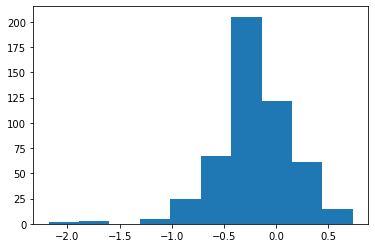

In [23]:
plt.hist((df_winter_combined_parents['Planned_Yield_kg_per_ha'] - df_winter_combined_parents['Yield_kg_per_Ha']) / df_winter_combined_parents['Planned_Yield_kg_per_ha'])

In [31]:
df = pd.read_csv('/mnt/Datasets/merged_df_wet_and_dry_3_20_23.csv').drop(columns = ['Unnamed: 0'])
df['dry_wet_ratio'] = df['Enter Dry Finished Yield Mass (kg)'] / df['Enter Total Wet Mass Harvested (kg)']
df_season = pd.read_excel('/mnt/Datasets/PC003_consolidated_new (1).xlsx')
df_season['Field Name'] = df_season['Contrato legal'].str[6:]
df_season = df_season[['Field Name', 'Safra']]
df_season = df_season.rename(columns = {'Safra': 'Season', 'Field Name': 'Field_Name'})
df_season = df_season.drop_duplicates().reset_index(drop = True)
df = df.merge(df_season, on = 'Field_Name', how = 'left')
df_combined_parents = df
df_combined_parents['Total_N'] = df_combined_parents['N_as_Urea_kg_per_Ha'] + df_combined_parents['N_as_Nitrate_kg_per_Ha'] + df_combined_parents['N_as_Ammonium_kg_per_Ha']
df_combined_parents['Total_P'] = df_combined_parents['P_as_Phosphorus_kg_per_Ha'] + df_combined_parents['P_as_P2O5_kg_per_Ha']
df_combined_parents['Total_K'] = df_combined_parents['K_as_Potassium_kg_per_Ha'] + df_combined_parents['K_as_K2O_kg_per_Ha']
df_combined_parents = df_combined_parents.drop(columns = ['N_as_Urea_kg_per_Ha', 'N_as_Nitrate_kg_per_Ha', 'N_as_Ammonium_kg_per_Ha', \
                                                          'P_as_Phosphorus_kg_per_Ha', 'P_as_P2O5_kg_per_Ha'])
print(display(df_combined_parents))

# #Winter
# df_winter = df[df['Season'] == 'WINTER'].reset_index(drop = True)[['Field_Name', 'Crop_Protection_Application_Doses', 'Soil_Organic_Matter', 'Yield_kg_per_Ha', \
#                                                                   'N_as_Urea_kg_per_Ha', 'N_as_Nitrate_kg_per_Ha', 'N_as_Ammonium_kg_per_Ha', 'P_as_Phosphorus_kg_per_Ha', \
#                                                                    'P_as_P2O5_kg_per_Ha', 'K_as_Potassium_kg_per_Ha', 'K_as_K2O_kg_per_Ha', 'dry_wet_ratio']]
# df_winter_combined_parents = df_combined_parents[df_combined_parents['Season'] == 'WINTER'].reset_index(drop = True)[['Field_Name', 'Crop_Protection_Application_Doses', 'Soil_Organic_Matter', 'Yield_kg_per_Ha', \
#                                                                   'Total_N', 'Total_P', 'Total_K', 'dry_wet_ratio']]

# print(display(df_winter_combined_parents))

hybrid_df = pd.read_excel('/mnt/Datasets/PC003_consolidated_new (1).xlsx')[['Hy', 'Contrato legal', 'MPL/Ha Plan']]
hybrid_df = hybrid_df.rename(columns = {'Hy': 'Hybrid', 'Contrato legal': 'Field_Name', 'MPL/Ha Plan': 'Planned_Yield_kg_per_ha'})
hybrid_df['Planned_Yield_kg_per_ha'] = hybrid_df['Planned_Yield_kg_per_ha']*100
hybrid_df['Field_Name'] = hybrid_df['Field_Name'].str[6:]
hybrid_df = hybrid_df.drop_duplicates()
print(display(hybrid_df))

df_combined_parents = df_combined_parents.merge(hybrid_df, on = 'Field_Name', how = 'left')
df_combined_parents = df_combined_parents[['Field_Name', 'CO2_kg_per_Ha', 'Crop_Protection_Application_Doses', 'Soil_Organic_Matter', 'Yield_kg_per_Ha', \
                                          'Total_N', 'Total_P', 'Total_K', 'Season', 'Hybrid', 'Planned_Yield_kg_per_ha']]
print(display(df_combined_parents))
# print(display(df_combined_parents))
# print(len(df_winter_parents['Hybrid'].unique()))

# df_winter_combined_parents = df_winter_combined_parents.drop(columns = ['dry_wet_ratio'])
df_combined_parents.to_csv('/mnt/Wet_yield_prediction/Organized_Work/Datasets/hybrid_planned_yield_dataset_all_seasons.csv'), 

,Field_Name,Harvest Year,CO2_kg_per_Ha,Total_Water_Applied_mm,Crop_Protection_Application_Doses,Enter Crop Area (ha),Enter Total Wet Mass Harvested (kg),Enter Dry Finished Yield Mass (kg),Soil_Organic_Matter,Yield_kg_per_Ha,Yield_kg_per_Ha_Dry,K_as_Potassium_kg_per_Ha,K_as_K2O_kg_per_Ha,dry_wet_ratio,Season,Total_N,Total_P,Total_K
0,M6I2035,2020,-220.35,350.0,14.0,60.0,182960.0,180200,2.500000,3049.333333,3003.333333,48.0,0.0,0.984915,WINTER,205.5,48.0,48.0
1,M6I2036,2020,3847.21,350.0,18.0,180.0,643510.0,418990,2.500000,3575.055556,2327.722222,216.0,0.0,0.651101,WINTER,492.0,216.0,216.0
2,M6I2037,2020,415.52,350.0,13.0,100.0,311620.0,305180,2.500000,3116.200000,3051.800000,60.0,0.0,0.979334,WINTER,198.0,60.0,60.0
3,M6I2009,2020,724.51,350.0,9.0,90.0,691100.0,335950,2.500000,7678.888889,3732.777778,96.0,0.0,0.486109,WINTER,202.4,95.2,96.0
4,M6I2010,2020,502.10,350.0,9.0,55.0,426600.0,215560,2.500000,7756.363636,3919.272727,90.0,0.0,0.505298,WINTER,179.4,95.2,90.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,M6I21197,2021,-239.89,350.0,15.0,83.0,338100.0,215140,2.597851,4073.493976,2592.048193,0.0,0.0,0.636321,WINTER,92.0,0.0,0.0
916,M6I21199,2021,314.80,350.0,17.0,62.0,432120.0,231010,3.120000,6969.677419,3725.967742,0.0,0.0,0.534597,WINTER,184.0,0.0,0.0
917,M6I21200,2021,-312.82,350.0,19.0,110.0,766660.0,409860,2.930000,6969.636364,3726.000000,0.0,0.0,0.534605,WINTER,92.0,0.0,0.0
918,M6I21201,2021,485.73,350.0,17.0,120.0,954560.0,480240,3.240000,7954.666667,4002.000000,0.0,0.0,0.503101,WINTER,207.0,0.0,0.0


None


,Hybrid,Field_Name,Planned_Yield_kg_per_ha
0,DKB265PRO3,M4V1934,6900.0
1,AS1844PRO3,M6V1924,5000.0
2,AG1051,M6V19115,9800.0
3,DKB345PRO3,M4V1937,5700.0
4,DKB363PRO3,M4V1938,5200.0
...,...,...,...
7151,DKB360PRO3,M4I2324,6300.0
7152,DKB360PRO3,M4I2305,6300.0
7153,AG7088PRO4,M4I2315,5500.0
7154,AS1596TRE,M4I2321,4300.0


None


,Field_Name,CO2_kg_per_Ha,Crop_Protection_Application_Doses,Soil_Organic_Matter,Yield_kg_per_Ha,Total_N,Total_P,Total_K,Season,Hybrid,Planned_Yield_kg_per_ha
0,M6I2035,-220.35,14.0,2.500000,3049.333333,205.5,48.0,48.0,WINTER,DKB335PRO3,4700.0
1,M6I2036,3847.21,18.0,2.500000,3575.055556,492.0,216.0,216.0,WINTER,DKB335PRO3,4700.0
2,M6I2037,415.52,13.0,2.500000,3116.200000,198.0,60.0,60.0,WINTER,DKB335PRO3,4700.0
3,M6I2009,724.51,9.0,2.500000,7678.888889,202.4,95.2,96.0,WINTER,AG8480PRO3,6300.0
4,M6I2010,502.10,9.0,2.500000,7756.363636,179.4,95.2,90.0,WINTER,AG8480PRO3,6300.0
...,...,...,...,...,...,...,...,...,...,...,...
915,M6I21197,-239.89,15.0,2.597851,4073.493976,92.0,0.0,0.0,WINTER,DKB360PRO3,5400.0
916,M6I21199,314.80,17.0,3.120000,6969.677419,184.0,0.0,0.0,WINTER,DKB360PRO3,5400.0
917,M6I21200,-312.82,19.0,2.930000,6969.636364,92.0,0.0,0.0,WINTER,DKB360PRO3,5400.0
918,M6I21201,485.73,17.0,3.240000,7954.666667,207.0,0.0,0.0,WINTER,DKB360PRO3,5800.0


None


(None,)